In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import seaborn as sns

## Input data

In [ ]:
# note for my future self:
# teststring = df_mod['Nom'][0] # get the first file name as a string
# timestring = teststring.split('_')[2][1:] # extracitng only the YYYYjjj portion from the string
# datetime.datetime.strptime(timestring, '%Y%j').date() # and this is converting it to datetime
# And this will do both:
# df_mod['Date'] = df_mod['Nom'].apply(lambda x: datetime.datetime.strptime(x.split('_')[2][1:], '%Y%j').date())

In [2]:
# Ground truth (André)
gtxls = 'D:\\processing\\OTHER_PLATFORMS\\andre_field_data_s3compat.xlsx'
df_gt = pd.read_excel(gtxls,sheet_name='gt', errors='coerce')
df_gt_srtd = df_gt.sort_values(by='Date')

# Sentinel-3
madeiraxls = 'MADEIRAv9b.xlsx'
df_s3 = pd.read_excel(madeiraxls,sheet_name='MADEIRAv9b')
# removes hour:minute:seconds from Sentinel-3 data.
df_s3['Date'] = [e.replace(hour=0, minute=0, second=0) for e in df_s3['Datetime']]
df_s3_srtd = df_s3.sort_values(by='Date')

# MODIS-Terra
f_mod = 'D:\\processing\\OTHER_PLATFORMS\\15860000_MOD09Q1_commun_noinf.xls'
df_mod = pd.read_excel(f_mod,sheet_name='MOD09Q1', converters={'Date': str})
df_mod['Date'] = df_mod['Nom'].apply(lambda x: datetime.datetime.strptime(x.split('_')[2][1:], '%Y%j').date())
df_mod_srtd = df_mod.sort_values(by='Date')
df_mod_srtd['Datetime'] = pd.to_datetime(df_mod_srtd['Date'], errors='coerce')

# MODIS-Aqua
f_myd = 'D:\\processing\\OTHER_PLATFORMS\\15860000_MYD09Q1_commun_noinf.xls'
df_myd = pd.read_excel(f_myd,sheet_name='MYD09Q1', converters={'Date': str})
df_myd['Date'] = df_myd['Nom'].apply(lambda x: datetime.datetime.strptime(x.split('_')[2][1:], '%Y%j').date())
df_myd_srtd = df_myd.sort_values(by='Date')
df_myd_srtd['Datetime'] = pd.to_datetime(df_myd_srtd['Date'], errors='coerce')

# VIIRS
f_vir = 'D:\\processing\\OTHER_PLATFORMS\\15860000_VNP09H1_commun_noinf.xls'
df_vir = pd.read_excel(f_vir,sheet_name='Report', converters={'Date': str})
df_vir['Date'] = df_vir['Nom'].apply(lambda x: datetime.datetime.strptime(x.split('_')[2][1:], '%Y%j').date())
df_vir_srtd = df_vir.sort_values(by='Date')
df_vir_srtd['Datetime'] = pd.to_datetime(df_vir_srtd['Date'], errors='coerce')

print('Summary:')
print('GT',len(df_gt_srtd),'min',df_gt_srtd['Date'].min(),'max',df_gt_srtd['Date'].max())
print('S3',len(df_s3_srtd),'min',df_s3_srtd['Date'].min(),'max',df_s3_srtd['Date'].max())
print('MOD',len(df_mod_srtd),'min',df_mod_srtd['Datetime'].min(),'max',df_mod_srtd['Datetime'].max())
print('MYD',len(df_myd_srtd),'min',df_myd_srtd['Datetime'].min(),'max',df_myd_srtd['Datetime'].max())
print('VIIRS',len(df_vir_srtd),'min',df_vir_srtd['Datetime'].min(),'max',df_vir_srtd['Datetime'].max())

Summary:
GT 291 min 2017-12-05 00:35:23 max 2019-05-17 00:33:45
S3 171 min 2016-05-14 00:00:00 max 2020-03-26 00:00:00
MOD 912 min 2000-02-26 00:00:00 max 2020-02-18 00:00:00
MYD 810 min 2002-07-04 00:00:00 max 2020-02-18 00:00:00
VIIRS 373 min 2012-01-17 00:00:00 max 2020-02-26 00:00:00


In [3]:
# drop flags not in 1 and 2

df_mod_srtd = df_mod_srtd[(df_mod_srtd['flag qualite'] == 1) | (df_mod_srtd['flag qualite'] == 2)].copy()
df_myd_srtd = df_myd_srtd[(df_myd_srtd['flag qualite'] == 1) | (df_myd_srtd['flag qualite'] == 2)].copy()
df_vir_srtd = df_vir_srtd[(df_vir_srtd['flag qualite'] == 1) | (df_vir_srtd['flag qualite'] == 2)].copy()

len(df_mod_srtd),len(df_myd_srtd),len(df_vir_srtd)

(816, 773, 346)

In [4]:
# Testing for duplicate entries over input data

s3_dp = df_s3_srtd.duplicated(keep=False,subset=['Date'])
mod_dp = df_mod_srtd.duplicated(keep=False,subset=['Date'])
myd_dp = df_myd_srtd.duplicated(keep=False,subset=['Date'])
vir_dp = df_vir_srtd.duplicated(keep=False,subset=['Date'])

len(df_s3_srtd[s3_dp]),len(df_mod_srtd[mod_dp]),len(df_myd_srtd[myd_dp]),len(df_vir_srtd[vir_dp])

(0, 0, 0, 0)

## Multiply the composite rows to fill in the missing day gaps 

In [5]:
terra = df_mod_srtd.set_index('Datetime').resample('1D').ffill().reset_index()
aqua = df_myd_srtd.set_index('Datetime').resample('1D').ffill().reset_index()
viirs = df_vir_srtd.set_index('Datetime').resample('1D').ffill().reset_index()

In [6]:
len(terra),len(aqua),len(viirs)

(7298, 6431, 2955)

## Match Sentinel-3 observations

In [7]:
mod_mats3 = terra[terra['Datetime'].isin(df_s3_srtd['Date'])]
myd_mats3 = aqua[aqua['Datetime'].isin(df_s3_srtd['Date'])]
vir_mats3 = viirs[viirs['Datetime'].isin(df_s3_srtd['Date'])]

In [8]:
len(mod_mats3),len(myd_mats3),len(vir_mats3),len(df_s3_srtd)

(167, 167, 167, 171)

## Removing te S3 measures out of the other sensor bounds

In [9]:
s3_out = df_s3_srtd[df_s3_srtd['Date'] > mod_mats3['Datetime'].max()].index
s3_mat_mod = df_s3_srtd.copy()
s3_mat_mod.drop(s3_out, inplace=True)
len(s3_mat_mod)

167

## CHECK IF EVERY SENSOR DATE FITS IN EACH OTHER'S

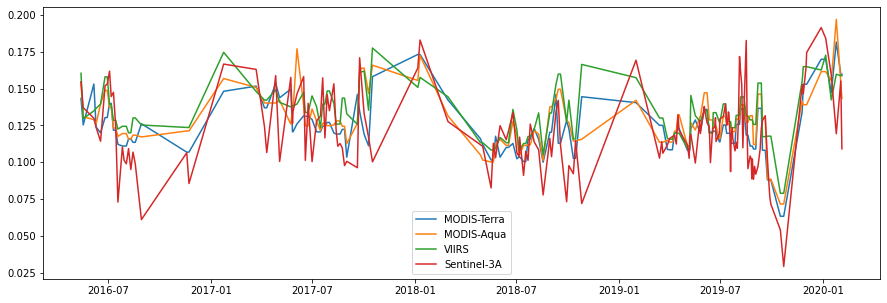

In [10]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(mod_mats3['Datetime'],mod_mats3['Bande rouge estimee']/10000,label='MODIS-Terra')
plt.plot(myd_mats3['Datetime'],myd_mats3['Bande rouge estimee']/10000,label='MODIS-Aqua')
plt.plot(vir_mats3['Datetime'],vir_mats3['Bande rouge estimee']/10000,label='VIIRS')
plt.plot(s3_mat_mod['Date'],s3_mat_mod['B8-665'],label='Sentinel-3A')
plt.legend()

## CREATING A SINGLE DF WITH ALL 4 SENSORS

In [14]:
# https://stackoverflow.com/questions/40339886/pandas-concat-generates-nan-values

s3_mat_mod.reset_index(drop=True, inplace=True)
mod_mats3.reset_index(drop=True, inplace=True)
myd_mats3.reset_index(drop=True, inplace=True)
vir_mats3.reset_index(drop=True, inplace=True)

rouge_data = pd.concat([s3_mat_mod['B8-665'],
                        mod_mats3['Bande rouge estimee']/10000,
                        myd_mats3['Bande rouge estimee']/10000,
                        vir_mats3['Bande rouge estimee']/10000], axis=1,
                       keys=['S3', 'MOD', 'MYD', 'VIR'])

rouge_data.index = s3_mat_mod['Date']

In [45]:
rouge_data.to_csv('sat_match.csv')

In [15]:
ir_data = pd.concat([s3_mat_mod['B17-865'],
                        mod_mats3['Bande IR estimee']/10000,
                        myd_mats3['Bande IR estimee']/10000,
                        vir_mats3['Bande IR estimee']/10000], axis=1,
                       keys=['S3', 'MOD', 'MYD', 'VIR'])

ir_data.index = s3_mat_mod['Date']

In [16]:
ir_data.to_csv('sat_match_ir.csv')

## PLOTING TO TEST IF IT WORKED

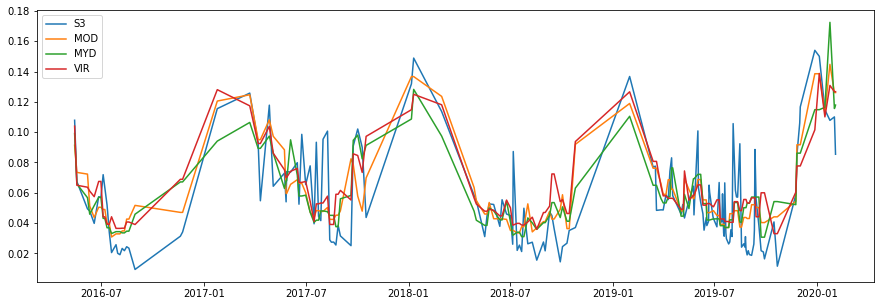

In [17]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(ir_data.S3,label='S3')
plt.plot(ir_data.MOD,label='MOD')
plt.plot(ir_data.MYD,label='MYD')
plt.plot(ir_data.VIR,label='VIR')
plt.legend()

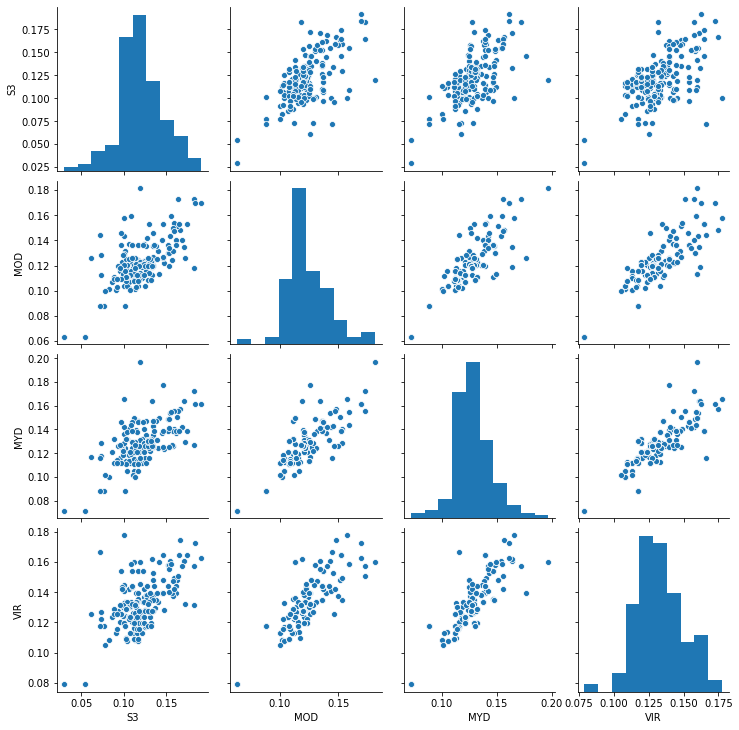

In [14]:
sns.pairplot(rouge_data)

## COMPUTING STATISTICS

## r²

In [25]:
from sklearn.metrics import r2_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

r2dict = {}

for sensor in list(ir_data.columns):
    for col in ir_data:
        result = r2_score(ir_data[sensor],ir_data[col]) # y_true / y_pred 
        r2dict[f'{sensor}:{col}'] = result

r2dict

{'S3:S3': 1.0,
 'S3:MOD': 0.5711474590448364,
 'S3:MYD': 0.5440297966316665,
 'S3:VIR': 0.5015520094395227,
 'MOD:S3': 0.34032367550298903,
 'MOD:MOD': 1.0,
 'MOD:MYD': 0.8230603947981123,
 'MOD:VIR': 0.8365006483109054,
 'MYD:S3': 0.18670817233520742,
 'MYD:MOD': 0.7948308360549469,
 'MYD:MYD': 1.0,
 'MYD:VIR': 0.7901965713333687,
 'VIR:S3': 0.043222567228727415,
 'VIR:MOD': 0.7959746185507138,
 'VIR:MYD': 0.7742157154770885,
 'VIR:VIR': 1.0}

## RMSE

In [32]:
from sklearn.metrics import mean_squared_error as mse

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmsedict = {}
rmsedict_yt = {}
rmsedict_yp = {}

for sensor in list(ir_data.columns):
    for col in ir_data:
        result = rmse(ir_data[col],ir_data[sensor])
        rmsedict[f'{sensor}:{col}'] = result
        rmsedict_yt[f'{sensor}:{col}'] = (result/ir_data[sensor].mean())*100 # y_true
        rmsedict_yp[f'{sensor}:{col}'] = (result/ir_data[col].mean())*100 # y_pred
        

print(rmsedict,'\n')

print(rmsedict_yt,'\n')
print(rmsedict_yp,'\n')

{'S3:S3': 0.0, 'S3:MOD': 0.020372799332532155, 'S3:MYD': 0.021007044015461978, 'S3:VIR': 0.02196375741924663, 'MOD:S3': 0.020372799332532155, 'MOD:MOD': 0.0, 'MOD:MYD': 0.010551101128282985, 'MOD:VIR': 0.010142459357963873, 'MYD:S3': 0.021007044015461978, 'MYD:MOD': 0.010551101128282985, 'MYD:MYD': 0.0, 'MYD:VIR': 0.010669597388840617, 'VIR:S3': 0.02196375741924663, 'VIR:MOD': 0.010142459357963873, 'VIR:MYD': 0.010669597388840617, 'VIR:VIR': 0.0} 

{'S3:S3': 0.0, 'S3:MOD': 37.54997621947909, 'S3:MYD': 38.71897967220126, 'S3:VIR': 40.482338991389405, 'MOD:S3': 35.54887018273662, 'MOD:MOD': 0.0, 'MOD:MYD': 18.410809342990706, 'MOD:VIR': 17.69776284372436, 'MYD:S3': 37.36612262758261, 'MYD:MOD': 18.767692319074573, 'MYD:MYD': 0.0, 'MYD:VIR': 18.978466657417822, 'VIR:S3': 36.57621300829745, 'VIR:MOD': 16.890222689302085, 'VIR:MYD': 17.768064878782234, 'VIR:VIR': 0.0} 

{'S3:S3': 0.0, 'S3:MOD': 35.54887018273662, 'S3:MYD': 37.36612262758261, 'S3:VIR': 36.57621300829745, 'MOD:S3': 37.5499762

## MAPE

In [26]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mapedict = {}

for sensor in list(ir_data.columns):
    for col in ir_data:
        result = mape(ir_data[sensor],ir_data[col])
        mapedict[f'{sensor}:{col}'] = result
        
mapedict

{'S3:S3': 0.0,
 'S3:MOD': 41.87846111136351,
 'S3:MYD': 41.94492311712625,
 'S3:VIR': 48.3330504656667,
 'MOD:S3': 30.384854598591254,
 'MOD:MOD': 0.0,
 'MOD:MYD': 12.946185756629289,
 'MOD:VIR': 14.883408414313386,
 'MYD:S3': 30.91313129677518,
 'MYD:MOD': 12.940319544283396,
 'MYD:MYD': 0.0,
 'MYD:VIR': 15.170503320303839,
 'VIR:S3': 31.09832861786431,
 'VIR:MOD': 13.086761817322765,
 'VIR:MYD': 13.187514699199914,
 'VIR:VIR': 0.0}

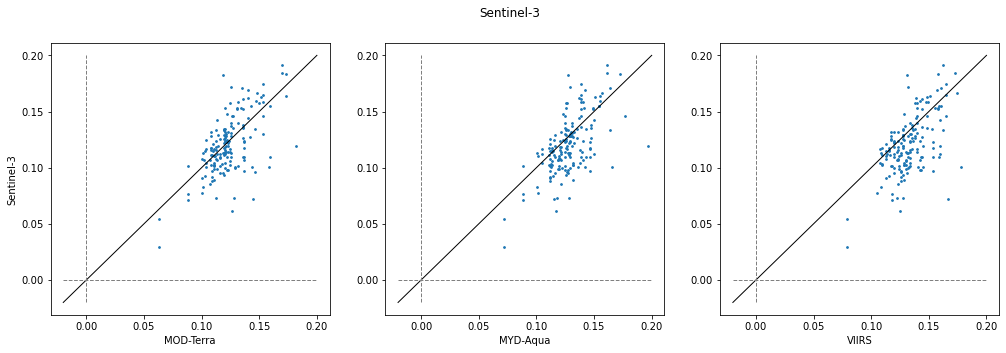

In [37]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.suptitle('Sentinel-3')

ax1.scatter(rouge_data.MOD, rouge_data.S3, s=3)
ax2.scatter(rouge_data.MYD, rouge_data.S3, s=3)
ax3.scatter(rouge_data.VIR, rouge_data.S3, s=3)


ax1.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax1.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax1.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax2.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax2.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax2.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax3.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax3.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax3.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)
# ax3.text(0.9, 0.1, 'r²', fontsize=12, horizontalalignment='center',
#          verticalalignment='center', transform=ax3.transAxes)

ax1.set_ylabel('Sentinel-3')

ax1.set_xlabel('MOD-Terra')
ax2.set_xlabel('MYD-Aqua')
ax3.set_xlabel('VIIRS')

plt.savefig('compare_s3.png', bbox_inches='tight')

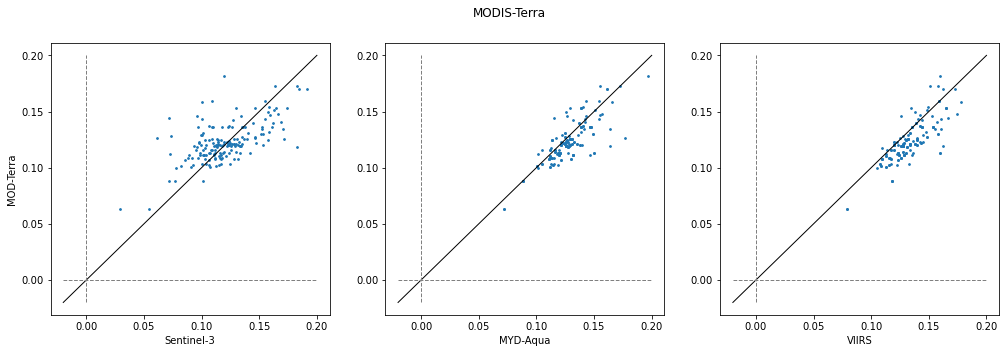

In [38]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.suptitle('MODIS-Terra')

ax1.scatter(rouge_data.S3, rouge_data.MOD, s=3)
ax2.scatter(rouge_data.MYD, rouge_data.MOD, s=3)
ax3.scatter(rouge_data.VIR, rouge_data.MOD, s=3)


ax1.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax1.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax1.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax2.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax2.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax2.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax3.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax3.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax3.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)
# ax3.text(0.9, 0.1, 'r²', fontsize=12, horizontalalignment='center',
#          verticalalignment='center', transform=ax3.transAxes)

ax1.set_ylabel('MOD-Terra')

ax1.set_xlabel('Sentinel-3')
ax2.set_xlabel('MYD-Aqua')
ax3.set_xlabel('VIIRS')

plt.savefig('compare_mod.png', bbox_inches='tight')

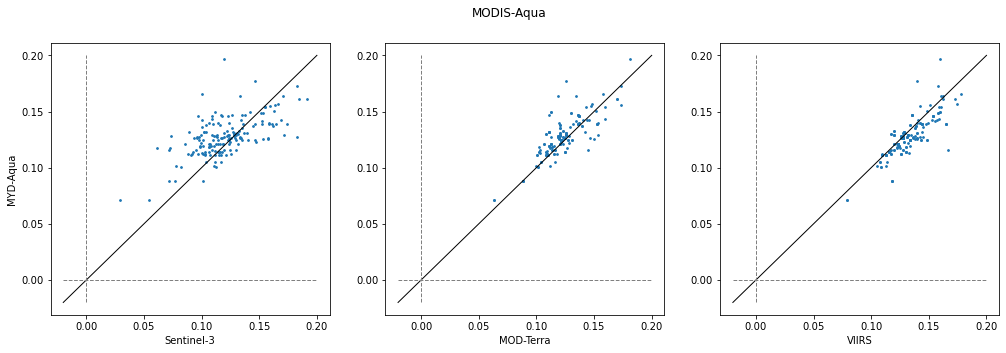

In [40]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.suptitle('MODIS-Aqua')

ax1.scatter(rouge_data.S3, rouge_data.MYD, s=3)
ax2.scatter(rouge_data.MOD, rouge_data.MYD, s=3)
ax3.scatter(rouge_data.VIR, rouge_data.MYD, s=3)


ax1.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax1.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax1.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax2.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax2.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax2.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax3.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax3.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax3.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)
# ax3.text(0.9, 0.1, 'r²', fontsize=12, horizontalalignment='center',
#          verticalalignment='center', transform=ax3.transAxes)

ax1.set_ylabel('MYD-Aqua')

ax1.set_xlabel('Sentinel-3')
ax2.set_xlabel('MOD-Terra')
ax3.set_xlabel('VIIRS')

plt.savefig('compare_myd.png', bbox_inches='tight')

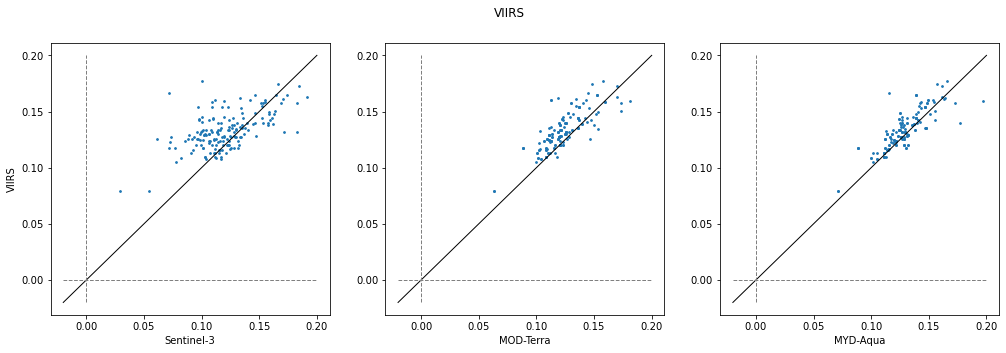

In [41]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.suptitle('VIIRS')

ax1.scatter(rouge_data.S3, rouge_data.VIR, s=3)
ax2.scatter(rouge_data.MOD, rouge_data.VIR, s=3)
ax3.scatter(rouge_data.MYD, rouge_data.VIR, s=3)


ax1.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax1.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax1.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax2.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax2.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax2.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax3.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax3.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax3.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)
# ax3.text(0.9, 0.1, 'r²', fontsize=12, horizontalalignment='center',
#          verticalalignment='center', transform=ax3.transAxes)

ax1.set_ylabel('VIIRS')

ax1.set_xlabel('Sentinel-3')
ax2.set_xlabel('MOD-Terra')
ax3.set_xlabel('MYD-Aqua')

plt.savefig('compare_vir.png', bbox_inches='tight')

## MATCHING 

In [ ]:
# generating a list of unique ground truth measurement dates
gt_uniquedate = [e.date() for e in df_gt['Date']]
gt_uniquedate = list(set(gt_uniquedate))
gt_uniquedate = pd.Series(gt_uniquedate)
gt_uniquedate

In [ ]:
## Which satellite image dates fall in the same date as the ground validation

In [ ]:
s3_matgt = df_s3_srtd[df_s3_srtd['Date'].isin(gt_uniquedate)]
mod_matgt = df_mod_srtd[df_mod_srtd['Date'].isin(gt_uniquedate)]
myd_matgt = df_myd_srtd[df_myd_srtd['Date'].isin(gt_uniquedate)]
vir_matgt = df_vir_srtd[df_vir_srtd['Date'].isin(gt_uniquedate)]
print(len(s3_matgt),len(mod_matgt),len(myd_matgt),len(vir_matgt),'\n')
print('Sentinel-3\n')
print(s3_matgt['Date'],'\n')
print('MOD-Terra\n')
print(mod_matgt['Date'],'\n')
print('MYD-Aqua\n')
print(myd_matgt['Date'],'\n')
print('VIIRS\n')
print(vir_matgt['Date'],'\n')

In [ ]:
## With the new rows, there should be more matches.

mod_matgt = terra[terra['Datetime'].isin(gt_uniquedate)]
myd_matgt = aqua[aqua['Datetime'].isin(gt_uniquedate)]
vir_matgt = viirs[viirs['Datetime'].isin(gt_uniquedate)]

print(len(mod_matgt),len(myd_matgt),len(vir_matgt),'\n')
print('MOD-Terra\n')
print(mod_matgt['Datetime'],'\n')
print('MYD-Aqua\n')
print(myd_matgt['Datetime'],'\n')
print('VIIRS\n')
print(vir_matgt['Datetime'],'\n')

## Manual dataframe repetition experiment

In [ ]:
# terra['Datetime'][0],df_s3_srtd['Date'][0]
terra_ex = terra.append( terra.iloc[[-1]*7] ).copy()
terra_fix = terra_ex.copy()

In [ ]:
# THIS WILL NOT WORK USING datetime.date or the ['Date'] column !!!
terra_ex_dp = terra_ex.duplicated(keep=False,subset=['Datetime'])

In [ ]:
len(terra_ex[terra_ex_dp]),terra_ex.index.max()

In [ ]:
for n,i in enumerate(range(terra_ex.index.max(),terra_ex.index.max()+8)):
    print(n,i,terra_ex['Datetime'].iloc[i] + datetime.timedelta(days=n))

In [ ]:
#OK, let's make it real.

for n,i in enumerate(range(terra_ex.index.max(),terra_ex.index.max()+8)):
    terra_fix['Datetime'].iloc[i] = terra_ex['Datetime'].iloc[i] + datetime.timedelta(days=n)

In [ ]:
mod_mats3 = terra_fix[terra_fix['Datetime'].isin(df_s3_srtd['Date'])]
len(mod_mats3)

In [ ]:
terra_fix.tail(11)